# Skin Cancer Classification Challenge

**Summary : ** skin cancer.

## Preliminaries and Imports

In [1]:
#general & system\n",
import os

#data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data augmentation
from PIL import Image
from random import choice
import cv2
import numpy as np
#import keras.preprocessing.image as prep

#ML part
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout,Activation,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score


from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

%matplotlib inline

Using TensorFlow backend.


## I. Load Data

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
%%time
meta = pd.read_csv("../data/label_learn.csv", sep = ";")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.7 ms


In [3]:
meta.head()

,name,label
0,0000000.jpg,benign
1,0000002.jpg,malignant
2,0000006.jpg,benign
3,0000008.jpg,benign
4,0000009.jpg,benign


In [4]:
%%time
train_list = os.listdir("../data/resized_train/")
len(train_list) == len(meta.name)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.86 ms


In [5]:
train_list.sort() == list(meta.name).sort()

True

In [6]:
%%time
X_train = np.array([np.array(Image.open("../data/resized_train/"+fname)) for fname in meta.name])
Y_train = [1 if x=="malignant" else 0 for x in meta.label]

CPU times: user 21.8 s, sys: 1.87 s, total: 23.6 s
Wall time: 23.6 s


In [7]:
print(X_train.shape)
print(len(Y_train))
X_train.shape[0] == len(meta.name) == len(Y_train)

(8581, 299, 299, 3)
8581


True

In [8]:
#control
print(meta.name[0:5])
print(Y_train[0:5])
print(meta.label[0:5])

0    0000000.jpg
1    0000002.jpg
2    0000006.jpg
3    0000008.jpg
4    0000009.jpg
Name: name, dtype: object
[0, 1, 0, 0, 0]
0       benign
1    malignant
2       benign
3       benign
4       benign
Name: label, dtype: object


## II. Data Preparation

- **Class weights**

In [9]:
class_weight_or = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

- **Data splitting**

- **Resampling**

In [11]:
temp = sum(Y_train)
sample_size = temp*2700/(374+254)  #1372
sample_size

8581
679
7902


In [12]:
def random_undersampling(X, Y,sample_size = sample_size, n_sample=1):
    """
    X,y : numpy arrays
    return :
    5 random ensemble of indices general_balenced_set:
        general_balenced_set[0] = the shuffeled indices that inssure the class balance
    """
    indices = np.array(range(len(Y)))
    positive_samples = indices[Y==1]
    #print(type(positive_samples))
    negative_samples = indices[Y==0]
    #print(type(negative_samples))
    general_balenced_set = []
    for k in range(n_sample):
        indices_ = np.random.choice(negative_samples, sample_size, replace=False)
        #print(len(indices_))
        # append positive and negative
        balenced_set = np.append(indices_, positive_samples)
        #print(len(balenced_set))
        # shuffle indices
        np.random.shuffle(balenced_set)
        #print(len(balenced_set))
        general_balenced_set.append(balenced_set)
    return general_balenced_set

In [ ]:
general_balenced_set = random_undersampling(X_train,Y_train)
X_train = X_train[general_balenced_set]
Y_train = Y_train[general_balenced_set]

## III. Deep Learning with Transfer Learning

In [13]:
weights_path = '../model/checkpoints/'

if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
epochs = 500
batch_size = 50

- **Using RESNET : **

In [ ]:
#load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299,299,3))
base_model.summary()

In [ ]:
#adding top layers
    #sequentialy
add_model = Sequential()
add_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:])) #Flatten/GlobalAveragePooling2D
add_model.add(Dense(1024, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.summary()

In [18]:
from keras import backend as K

def weighted_categorical_crossentropy(weights):
    """
    [w_0, w_1] : weight of 0 class and weight of 1 class
    """
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        #y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights[1] + (1 - y_true) * K.log(1 - y_pred) * weights[0]
        loss = -K.sum(loss, -1)
        return loss

    return loss



from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [15]:
class_weight_or

array([ 0.54296381,  6.31885125])

In [17]:
loss1 = weighted_categorical_crossentropy(np.array([1.8,6]))

In [ ]:
#freeze lower layers of the model
#for layer in model.layers[:]:
    #layer.trainable = False
for layer in model.layers[0:]:
    layer.trainable = True
    


#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=loss1, #binary_crossentropy
              metrics=[sensitivity, specificity,"accuracy"])

In [ ]:
%%time
#Lets define the image transormations that we wan

gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         rotation_range=40)

val_datagen = ImageDataGenerator()
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_one_input(X1, y):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]

def val_datagen_(X1, y):
    genX1 = val_datagen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]
#Finally create out generator
gen_flow_train = gen_flow_for_one_input(X_train, Y_train)
#gen_flow_val = gen_flow_for_one_input(X_valid, Y_valid)
#gen_flow_val = val_datagen_(X_valid, Y_valid)

from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs_to_wait_for_improve = 20
early_stopping_callback = EarlyStopping(monitor='loss',min_delta = 0.01, patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint(weights_path + 'BestKerasResnet50_flat_2_full.h5', monitor='val_loss',
                                      verbose=1, save_best_only=True, mode='min')
#fit the model
model.fit_generator(gen_flow_train,
                    steps_per_epoch=int(np.ceil(len(X_train)/batch_size)),
                    epochs=500, verbose=1, callbacks=[early_stopping_callback, checkpoint_callback],
                    class_weight = class_weight_or)

## IV. Visualize  TSNE

In [ ]:
%matplotlib inline
import numpy as np
# visualize the points' distribution of train data using features built from base_model
import matplotlib.pyplot as plt
# dimension reduction
from sklearn.manifold import TSNE 
import numpy as np

def t_sne_vis(name, base_model, x_processed_images, random_state, labels):
    """
    :param name: the name of the cnn model used to build features
    :param base_model: the model obj
    :param x_processed_images: the input images for our model
    :param random_state: for fixing the results
    :param labels: 0/1 classification labels
    :return:
    the graph of image distribution based on features extracted from the model and the t-sne features
    """
    # convert data to images
    print('Converting data points to composite image')
    X_train = x_processed_images
    print('we got %d different images of shape %dx%d ' % (len(X_train), X_train.shape[1], X_train.shape[1]))
    print('build usefull features from the selected model')
    features = base_model.predict(X_train)
    x_data1 = np.asarray(features).astype('float64')
    x_data1 = x_data1.reshape((x_data1.shape[0], -1))
    # perform t-SNE embedding
    print('performing t-sne reduction')
    vis_data = TSNE(perplexity=100, random_state=random_state).fit_transform(x_data1)
    # plot the result
    fig = plt.figure(figsize=(15, 15))
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("winter", 2))
    plt.colorbar(ticks=range(2))
    plt.clim(0, 1)
    plt.title(name)
    plt.grid()
    plt.show()
    fig.savefig('tsne_vis_'+name+'.png')
    return vis_data


In [ ]:
model.summary()

In [ ]:
name = 'Resnet'
print('visualizing for %s' %name)
base_model_ = Model(input=model.input, output=model.get_layer('avg_pool').output)
tsne_feats = t_sne_vis(name, base_model_, X_valid, np.random.RandomState(42), Y_valid)

## V. Evaluate Model

In [20]:
model = load_model(weights_path+"BestKerasResnet50_flat_3_loss_no_weight_raw.h5", custom_objects={'sensitivity': sensitivity,
                                                                             "specificity":specificity,
                                                                              "loss1":loss1})
score = model.evaluate(X_train, Y_train, verbose=1)
print('Test loss:', score[0])
print('Test sensitivity:', score[1])
print('Test specificity:', score[2])
print('Test acc:', score[3])

8581/8581 [==============================] - 48s 6ms/step
('Test loss:', 0.096961811329991876)
('Test sensitivity:', 0.16887641778262868)
('Test specificity:', 0.98164011368369763)
('Test acc:', 0.9594452861041376)


In [21]:
#compute metrics
pred = model.predict(X_train)
average_precision = average_precision_score(Y_train, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.81


Text(0.5,1,u'2-class Precision-Recall curve: AP=0.81')

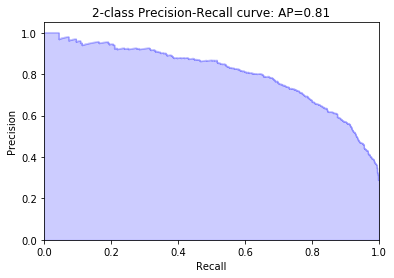

In [22]:
precision, recall, _ = precision_recall_curve(Y_train, pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)

#compute log loss
pred = model.predict(X_valid)
log_loss(Y_valid,pred)

## VI. Submit

In [32]:
test_list = os.listdir("../data/resized_test/")
test = pd.read_csv("../data/example.csv",sep = ";")

In [38]:
len(test_list) == len(test)

True

In [33]:
test["risk"] = test["risk"].apply(lambda x : float(x.replace(",",".")))
test.risk.mean()

0.5009030541978553

In [37]:
submission = pd.DataFrame()
submission["name"] = test.name

X_test = np.array([np.array(Image.open("../data/resized_test/"+fname)) for fname in test.name])
X_test.shape




(4291, 299, 299, 3)

In [39]:
pred = model.predict(X_test)
print(pred.shape)

submission["prediction"] = pred
submission.to_csv("submission_Resnet50_finetu.csv",index=False,sep=";")

(4291, 1)


In [40]:
submission

,name,prediction
0,0000001.jpg,0.161760
1,0000003.jpg,0.115472
2,0000004.jpg,0.032326
3,0000005.jpg,0.146522
4,0000007.jpg,0.064424
5,0000010.jpg,0.026847
6,0000013.jpg,0.310791
7,0000015.jpg,0.120671
8,0000021.jpg,0.545047
9,0000022.jpg,0.237165
